


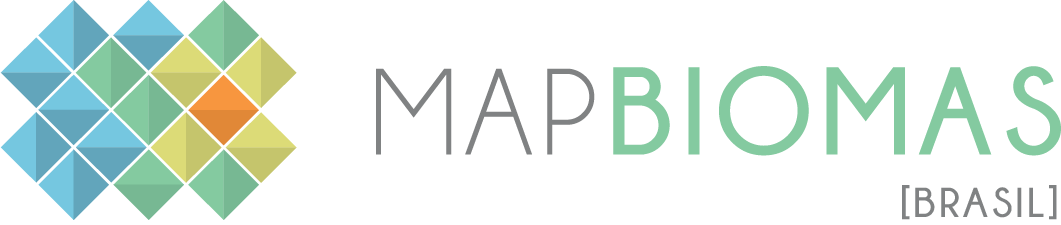
This Notebook use a MapBiomas trained model to map center pivot irrigation by instance segmentation 

# Configure your enviroment

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Install Pytorch and detectron2 library

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install rasterio

Import libraries

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


# import some common libraries
import numpy as np
import glob 
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import rasterio

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import transforms as T
from tqdm import tqdm
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances



#############-------------OTIMIZADOR
import copy
import itertools
import logging
from collections import defaultdict
from enum import Enum
from typing import Any, Callable, Dict, Iterable, List, Optional, Set, Type, Union
import torch
from fvcore.common.param_scheduler import CosineParamScheduler, MultiStepParamScheduler

from detectron2.config import CfgNode

from tqdm import tqdm

import os
from detectron2.data import DatasetMapper, build_detection_train_loader   # the default mapper
import detectron2.data.transforms as T
## Adding the new CascadeDropoutROIHeads to the config file



# Import the MapBiomas trained model

In [ ]:
input_dir_model = '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/Predict/trained_model'

Settings

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()  # obtain detectron2's default config
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")) 


cfg.DATALOADER.NUM_WORKERS = 2


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2 

cfg.SOLVER.MAX_ITER = 2000 
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # PIVOT classe

cfg.MODEL.ROI_MASK_HEAD.CONV_DIM = 512
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128, 256, 512, 1024]]
cfg.INPUT.MASK_FORMAT = "polygon"

configure model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(input_dir_model, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Run predict

In [ ]:
input_dir_images = '/content/drive/MyDrive/Colab Notebooks/Instance_Segmentation_center_pivot_irrigation/Predict/to_predict'
output_dir = input_dir_images + '/predicted'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


folder_predict = glob.glob(input_dir_images)


save = 0

n = 0 

for path in folder_predict:

    imgs = [f for f in glob.glob(path + "/*mosaic.tif", recursive=True)]

    for image_path in imgs:
        
        img = rasterio.open(image_path)
        im = cv2.imread(image_path)
        
        # print (image_path)

        outputs = predictor(im)
        # print (outputs)

        save = 0

        for i in range(1, len(outputs["instances"].to("cpu").pred_masks)):        
            n = n + i
            mask_pred = outputs["instances"].to("cpu").pred_masks[i]
            print ('mask_pred-------------')
            rf_array = mask_pred.reshape(im.shape[0], im.shape[1]).type(torch.int32).numpy()
            rf_array[rf_array == 1] = n 
            save += rf_array 
            image_name = image_path.split('/')[-1]
            print (image_name)
            
            with rasterio.open(output_dir + '/{}'.format(image_name),
                                'w',
                            driver = 'GTiff',
                            height=img.shape[0],
                            width=img.shape[1],
                            count=1,
                            dtype=save.dtype,
                            crs=img.crs,
                            nodata=None, # change if data has nodata value
                            transform=img.transform) as new_file:
                            new_file.write(save, 1)
            
        del save
                    
        

# Pivot intersection correction 

In [ ]:
def find_two_sum_dict(numbers, sum): 
  visitados = []
  for i in range(len(numbers)):
      dif = sum - numbers[i]
      if dif in visitados:
          return [dif, numbers[i]]
        
      visitados.append(numbers[i])

def exclude_overlap_pivot (path_image, output_dir_images):

  '''
    path_image: caminho da imagem '*mosaic.tif'
    output_dir_images: caminho para salvar as imagens sem sobreposição de pivôs

  '''
  img = rasterio.open(image_path)
  image_name = path_image.split('/')[-1]

  img_matrix = img.read(1)
  lista_ids = img_matrix.flatten().tolist() #juntar em uma única lista
  pivos_id_func = sorted(set(lista_ids)) #removeer numeros repetidos ordenar

  cont = len(pivos_id_func)*len(pivos_id_func)#Ultima linha do for para somar todas 

  lista = list()

  for valor in pivos_id_func:
    somas = [valor + val for val in pivos_id_func]
    lista += somas
    if len(lista) == cont:
          soma_pivos = lista
    
  soma_pivos = sorted(set(soma_pivos))
  soma_pivos = soma_pivos[len(pivos_id_func):]

  ID_fake = list((set(soma_pivos) & set(pivos_id_func))) #comparar as duas listas de ID e de somas
  ID_fake.sort()  


  if (len(ID_fake) > 0):

    result = list()

    for id_sobrep in ID_fake:

      res = find_two_sum_dict(pivos_id_func, id_sobrep)   
      result.append(res) 

      # print(len(ID_fake))

      if len(result) == len(ID_fake):
        resultado_final = result # pares ordenados 
        Lista_resultado_final = []
        [Lista_resultado_final.extend(i) for i in resultado_final] #lista unica 

        id_parOrdenado= []

        for x in range(0,len(Lista_resultado_final),2): #selecionar o pirmiero ID de cada par odernado 
          id_parOrdenado.append(Lista_resultado_final[x])

        # print (id_parOrdenado)
        # print (ID_fake)

        array_Lista_resultado_final = np.array(id_parOrdenado) 
        array_ID_fake = np.array(ID_fake) 

        
        x = 0

        
        print ('----------IMAGEM {} COM SOBREPOSIÇÃO DE {} PIVÔS--------'.format(image_name, len(ID_fake)))

      
        while x < len(array_ID_fake):     
          for j in array_ID_fake:
              img_matrix[img_matrix == array_ID_fake[x]] = array_Lista_resultado_final[x] #onde é 1 vai trocar por i (ou seja o passo do loop)
              x = x + 1   

              with rasterio.open(output_dir_images + '/{}'.format(image_name),
                          'w',
                        driver = 'GTiff',
                        height=img_matrix.shape[0],
                        width=img_matrix.shape[1],
                        count=1,
                        dtype=img_matrix.dtype,
                        crs=img.crs,
                        nodata=None, # change if data has nodata value
                        transform=img.transform) as new_file:
                        new_file.write(img_matrix, 1) 


  else:
    print ('----------IMAGEM {} COM SOBREPOSIÇÃO DE {} PIVÔS--------'.format(image_name, len(ID_fake)))

    with rasterio.open(output_dir_images + '/{}'.format(image_name),
            'w',
          driver = 'GTiff',
          height=img_matrix.shape[0],
          width=img_matrix.shape[1],
          count=1,
          dtype=img_matrix.dtype,
          crs=img.crs,
          nodata=None, # change if data has nodata value
          transform=img.transform) as new_file:
          new_file.write(img_matrix, 1) 

In [ ]:
output_dir_images = output_dir + '/predict_overlap_correction'

if not os.path.exists(output_dir_images):
    os.makedirs(output_dir_images)


folder_predict = glob.glob(output_dir)


for path in folder_predict:

    imgs = [f for f in glob.glob(path + "/*.tif", recursive=True)]

    for image_path in imgs:
        
        ID_fake = (exclude_overlap_pivot(image_path, output_dir_images))